# Importing the right libraries


In [1]:
from warnings import filterwarnings

filterwarnings("ignore")

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.decomposition import PCA

# Own modules in /src/
from neural_networks.rbf_layer import RBFLayer, InitCentersRandom
from utility.stats import check_stationarity
from utility.utils import compute_trend_target_on_dataframe
from filters.unscented_kalman_filter import UnscentedKalmanFilter
from backtest.reports import plot_from_trade_df, print_backtest_report
from backtest.backtester import backtest_startegy

Loading BokehJS ...

# Load the data (once)

## Reading the files


In [2]:
df = pd.read_excel(
    "../data/APPLE.xlsx", sheet_name="Feuil1", names=["date", "prices"], skiprows=0
).iloc[-20000:]

df["returns"] = df["prices"].pct_change()
df["returns_1H"] = df["prices"].pct_change(60)
df["returns_2H"] = df["prices"].pct_change(60 * 2)
df["returns_5H"] = df["prices"].pct_change(60 * 5)
df["returns_24H"] = df["prices"].pct_change(60 * 24)
df["EMA_returns_24H"] = df["returns_24H"].ewm(span=100).mean()
df["returns_48H"] = df["prices"].pct_change(60 * 24 * 2)
# df["variance"] = df["returns"].rolling(100).var()

df["vol"] = (
    df["returns"].rolling(100).std().apply(lambda x: x * np.sqrt(252 * 60 * 6.5))
)
# df["volvol"] = df["vol"].rolling(100).std()
df["backward_linear_reg_1H"] = (
    df["prices"].rolling(60).apply(lambda x: np.polyfit(range(len(x)), x, 1)[0])
)
df["backward_linear_reg_2H"] = (
    df["prices"].rolling(60 * 2).apply(lambda x: np.polyfit(range(len(x)), x, 1)[0])
)
df["backward_linear_reg_5H"] = (
    df["prices"].rolling(60 * 5).apply(lambda x: np.polyfit(range(len(x)), x, 1)[0])
)
df["backward_linear_reg_24H"] = (
    df["prices"].rolling(60 * 24).apply(lambda x: np.polyfit(range(len(x)), x, 1)[0])
)

df = df.dropna().reset_index(drop=True)
print(df.shape)
df.head()

(17120, 14)


date  prices   returns  returns_1H  returns_2H  returns_5H  \
0 2023-12-01 11:18:00  190.12  0.000000   -0.000105   -0.000421    0.007045   
1 2023-12-01 11:20:00  190.11 -0.000053   -0.000105   -0.000473    0.006832   
2 2023-12-01 11:21:00  190.10 -0.000053   -0.000210   -0.000473    0.006246   
3 2023-12-01 11:22:00  190.07 -0.000158    0.000210   -0.000789    0.005874   
4 2023-12-01 11:24:00  190.05 -0.000105   -0.000368   -0.000736    0.005662   

   returns_24H  EMA_returns_24H  returns_48H       vol  \
0    -0.008190        -0.004239    -0.001995  0.064521   
1    -0.008656        -0.004327    -0.002257  0.064521   
2    -0.008863        -0.004417    -0.002257  0.064541   
3    -0.009020        -0.004508    -0.002257  0.064707   
4    -0.009744        -0.004612    -0.002310  0.064761   

   backward_linear_reg_1H  backward_linear_reg_2H  backward_linear_reg_5H  \
0                0.000205                0.000322                0.002268   
1               -0.000019                0.000299                0.002195   
2               -0.000240                0.000270                0.002127   
3               -0.000695                0.000241                0.002059   
4               -0.001033                0.000192                0.001991   

   backward_linear_reg_24H  
0                -0.000348  
1                -0.000340  
2                -0.000332  
3                -0.000324  
4                -0.000316

## Adding the target (predict the next couple of hour trend)

The next couple of hour trend is refered as the target variable. The target variable the coefficient from the forward looking linear regression.


In [3]:
df = compute_trend_target_on_dataframe(
    df,
    original_feature="prices",
    forward_window=60 * 4,
    target_name="target",
    regression_type="linear",
)
df['target'] = df['target'].diff().fillna(0)
df.head()

Calculating targets: 100%|██████████| 16880/16880 [00:19<00:00, 885.73it/s] 


date  prices   returns  returns_1H  returns_2H  returns_5H  \
0 2023-12-01 11:18:00  190.12  0.000000   -0.000105   -0.000421    0.007045   
1 2023-12-01 11:20:00  190.11 -0.000053   -0.000105   -0.000473    0.006832   
2 2023-12-01 11:21:00  190.10 -0.000053   -0.000210   -0.000473    0.006246   
3 2023-12-01 11:22:00  190.07 -0.000158    0.000210   -0.000789    0.005874   
4 2023-12-01 11:24:00  190.05 -0.000105   -0.000368   -0.000736    0.005662   

   returns_24H  EMA_returns_24H  returns_48H       vol  \
0    -0.008190        -0.004239    -0.001995  0.064521   
1    -0.008656        -0.004327    -0.002257  0.064521   
2    -0.008863        -0.004417    -0.002257  0.064541   
3    -0.009020        -0.004508    -0.002257  0.064707   
4    -0.009744        -0.004612    -0.002310  0.064761   

   backward_linear_reg_1H  backward_linear_reg_2H  backward_linear_reg_5H  \
0                0.000205                0.000322                0.002268   
1               -0.000019                0.000299                0.002195   
2               -0.000240                0.000270                0.002127   
3               -0.000695                0.000241                0.002059   
4               -0.001033                0.000192                0.001991   

   backward_linear_reg_24H    target  
0                -0.000348  0.000000  
1                -0.000340  0.000060  
2                -0.000332  0.000063  
3                -0.000324  0.000059  
4                -0.000316  0.000043

Text(0.5, 1.0, 'Zoom - Stock Price and Target')

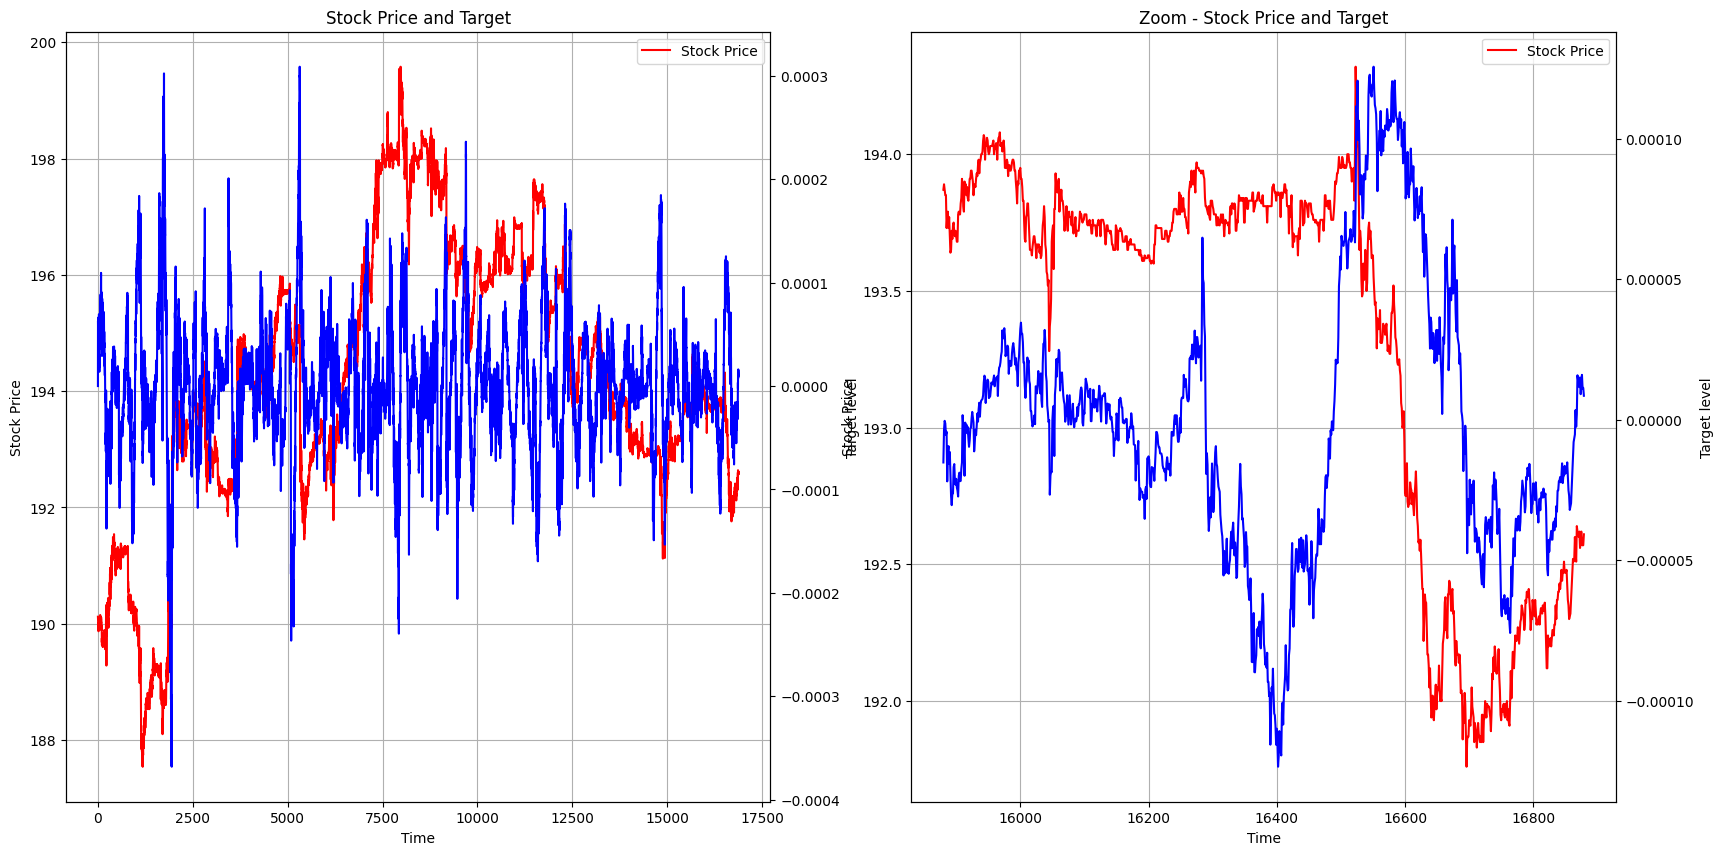

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].plot(df.prices, color="red", label="Stock Price")
axl = ax[0].twinx()
axl.plot(df.target, color="blue", label="Target")
axl.set_ylabel("Target level")
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Stock Price")
ax[0].legend()
ax[0].grid()
ax[0].set_title("Stock Price and Target")

ax[1].plot(df.prices.iloc[-1000:], color="red", label="Stock Price")
axl = ax[1].twinx()
axl.plot(df.target.iloc[-1000:], color="blue", label="Target")
axl.set_ylabel("Target level")
ax[1].set_xlabel("Time")
ax[1].set_ylabel("Stock Price")
ax[1].legend()
ax[1].grid()
ax[1].set_title("Zoom - Stock Price and Target")

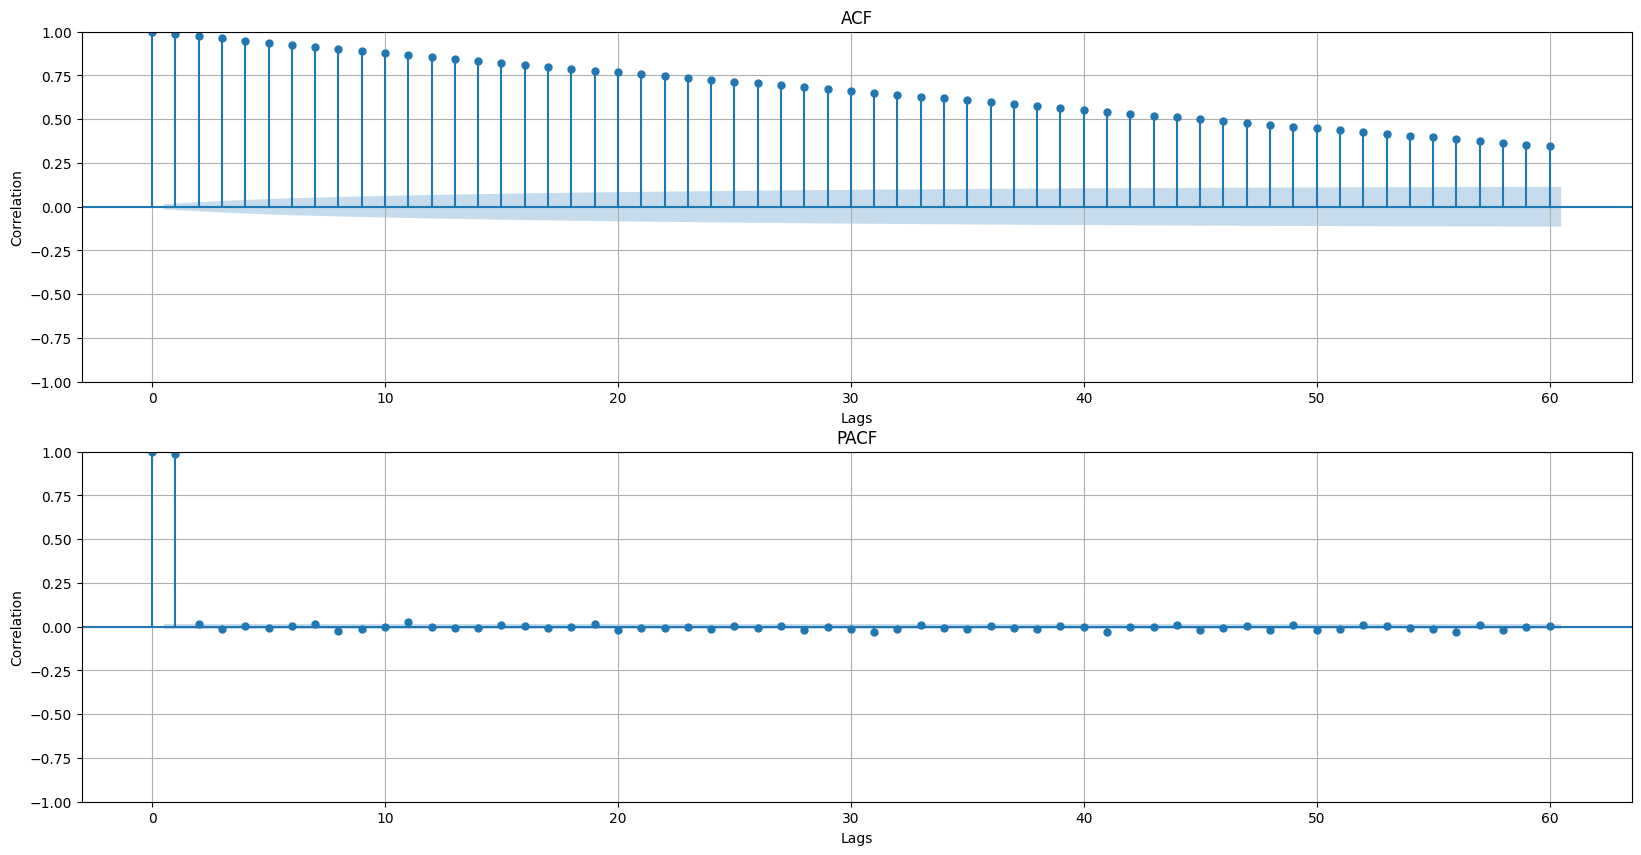

In [5]:
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(20, 10))
plot_acf(df.target, lags=60, ax=ax[0])
plot_pacf(df.target, lags=60, ax=ax[1])


ax[0].set_title("ACF")
ax[1].set_title("PACF")
ax[0].set_xlabel("Lags")
ax[1].set_xlabel("Lags")
ax[0].set_ylabel("Correlation")
ax[1].set_ylabel("Correlation")
ax[0].grid()
ax[1].grid()

plt.show()
# check_stationarity(df.target)

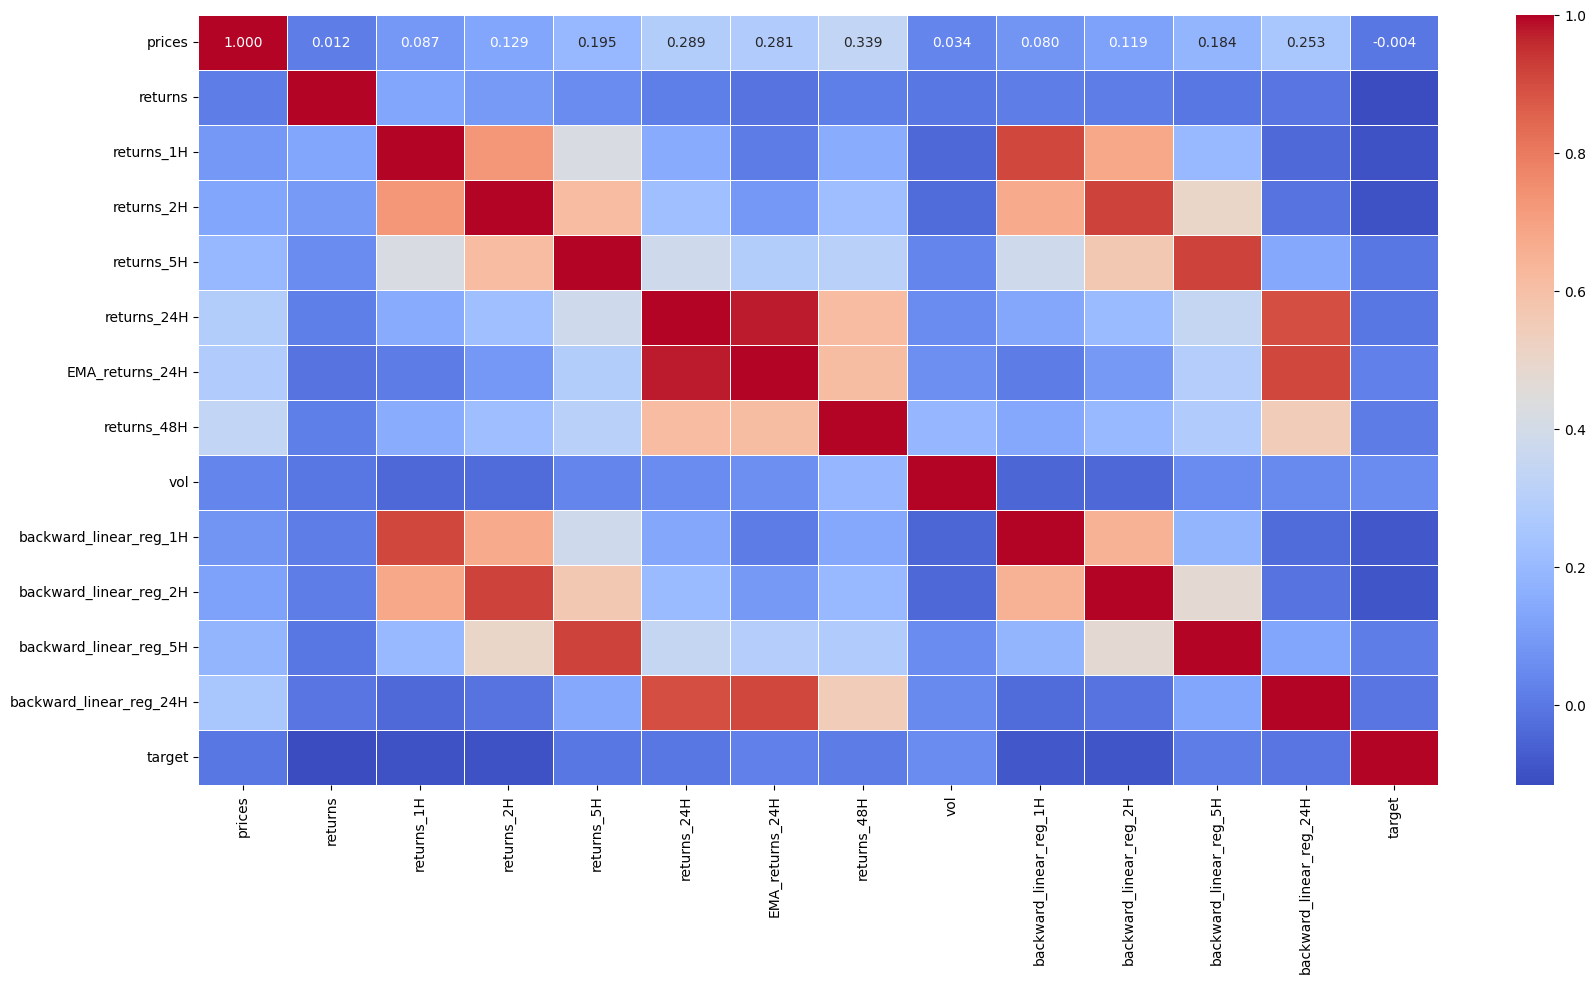

In [6]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 10))
sns.heatmap(df.corr(), cmap="coolwarm", fmt=".3f", linewidths=0.5, annot=True)

plt.show()

### Backtesting the perfect signal

In [7]:
df, trades_df = backtest_startegy(
    df,
    buying_threshold=0,
    selling_threshold=0,
    price_column="prices",
    returns_column="returns",
    date_column="date",
    signal_column="target",
    verbose=False,
    trading_fee=0,
    slippage_effect=0,
)

Backtesting...: 100%|██████████| 16880/16880 [00:05<00:00, 3205.56it/s]


In [8]:
print_backtest_report(trades_df, df, "1min", initial_equity=1000)
plot_from_trade_df(df)


------------  Strategy performances  -------------
Strategy final net balance: 990.50 $, return: -0.95 %
Buy & Hold final net balance: 1013.10 $, returns: 1.31 %
Strategy winrate ratio: 60.00 %
Strategy payoff ratio: 2.97
Strategy profit factor ratio: 6.39
Strategy expectancy: 171.19 %

-------  Returns statistical information  --------
Expected return annualized: -29.54 % vs 43.75 % (buy and hold)
CAGR: -25.72 % vs 49.95 % (buy and hold)
Expected volatility annualized: 6.35 % vs 25.43 % (buy and hold)
Specific volatility (diversifiable) annualized: 6.15 %
Systematic volatility annualized: 1.59 %
Skewness: -6.78 vs -0.20 (buy and hold), <0 = left tail, >0 = right tail
Kurtosis: 318.10 vs -0.20 (buy and hold) , >3 = fat tails, <3 = thin tails
1min-95%-VaR: 0.00 % vs -0.05 % (buy and hold) -> the lower the better
1min-95%-CVaR: -0.03 % vs -0.08 % (buy and hold) -> the lower the better

-------  Strategy statistical information  -------
Max drawdown: -1.76 % vs -4.24 % (buy and hold)
Kel

Loading BokehJS ...

## Creating train and test data sets


In [9]:
df.columns

Index(['date', 'prices', 'returns', 'returns_1H', 'returns_2H', 'returns_5H',
       'returns_24H', 'EMA_returns_24H', 'returns_48H', 'vol',
       'backward_linear_reg_1H', 'backward_linear_reg_2H',
       'backward_linear_reg_5H', 'backward_linear_reg_24H', 'target',
       'strategy_returns', 'strategy_cum_returns', 'cum_returns', 'drawdown',
       'strategy_drawdown'],
      dtype='object')

In [10]:
X = df[['prices', 'returns', 'returns_1H', 'returns_2H', 'returns_5H',
       'returns_24H', 'EMA_returns_24H', 'returns_48H', 'vol',
       'backward_linear_reg_1H', 'backward_linear_reg_2H',
       'backward_linear_reg_5H', 'backward_linear_reg_24H']].to_numpy()
Y = df["target"].to_numpy().reshape(-1, 1)

TEST_PERCENT = 0.35
TRAIN_PERCENT = 1 - TEST_PERCENT

X_train = X[: int(X.shape[0] * TRAIN_PERCENT)]
X_test = X[int(X.shape[0] * TRAIN_PERCENT) :]
Y_train = Y[: int(Y.shape[0] * TRAIN_PERCENT)]
Y_test = Y[int(Y.shape[0] * TRAIN_PERCENT) :]
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((10972, 13), (5908, 13), (10972, 1), (5908, 1))

## Scaling/normilizing the data


In [11]:
X_train_scaler = RobustScaler()  # MinMaxScaler() # RobustScaler() # StandardScaler()
X_train_scaled = X_train_scaler.fit_transform(X_train)

X_test_scaler = RobustScaler()  # MinMaxScaler() # RobustScaler() # StandardScaler()
X_test_scaled = X_test_scaler.fit_transform(X_test)

Y_train_scaler = MinMaxScaler()  # MinMaxScaler() # RobustScaler() # StandardScaler()
Y_train_scaled = Y_train_scaler.fit_transform(Y_train)

Y_test_scaler = MinMaxScaler()  # MinMaxScaler() # RobustScaler() # StandardScaler()
Y_test_scaled = Y_test_scaler.fit_transform(Y_test)

X_train_scaled.shape, X_test_scaled.shape, Y_train_scaled.shape, Y_test_scaled.shape

((10972, 13), (5908, 13), (10972, 1), (5908, 1))

## Reducing the dimension of X with PCA

This step is not necessary but it is a good practice to reduce the dimension of the data. It will help to reduce the computational time and the noise in the data by removing the less important features.


In [12]:
pca_X_train = PCA(n_components=6)
X_train_scaled_reduced = pca_X_train.fit_transform(X_train_scaled)
print(
    f"Total explained variance (train set): {100*sum(pca_X_train.explained_variance_ratio_):.2f}%"
)

pca_X_test = PCA(n_components=6)
X_test_scaled_reduced = pca_X_test.fit_transform(X_test_scaled)
print(
    f"Total explained variance (test set): {100*sum(pca_X_test.explained_variance_ratio_):.2f}%"
)

Total explained variance (train set): 92.00%
Total explained variance (test set): 92.97%


# Neural networks

### Defining the model


In [13]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input((X_train_scaled_reduced.shape[-1], 1)))
model.add(
    RBFLayer(
        output_dim=16,
        initializer=InitCentersRandom(X_train_scaled_reduced),
        betas=1.0,
        input_shape=(X_train_scaled_reduced.shape[-1],),
    )
)
model.add(tf.keras.layers.Reshape((1, 16)))
model.add(
    tf.keras.layers.LSTM(
        units=32, activation="relu", dropout=0.1, return_sequences=False
    )
)
model.add(tf.keras.layers.Dense(1))

# Compile the model
model.compile(
    optimizer="adam", loss="mean_squared_error", metrics=["mean_squared_error"]
)

### Training the model


In [14]:
# Train the model
history = model.fit(
    X_train_scaled_reduced,
    Y_train_scaled,
    batch_size=64,
    epochs=20,
    validation_split=0.2,
    shuffle=False,
    verbose=1,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss",
            verbose=1,
            patience=5,
            mode="min",
            restore_best_weights=True,
        )
    ],
    use_multiprocessing=True,
)
model.save("../models/rbf_lstm.h5")

Epoch 1/20


138/138 [==============================] - 7s 12ms/step - loss: 0.1645 - mean_squared_error: 0.1645 - val_loss: 0.0391 - val_mean_squared_error: 0.0391
Epoch 2/20
138/138 [==============================] - 1s 8ms/step - loss: 0.0203 - mean_squared_error: 0.0203 - val_loss: 0.0112 - val_mean_squared_error: 0.0112
Epoch 3/20
138/138 [==============================] - 1s 8ms/step - loss: 0.0120 - mean_squared_error: 0.0120 - val_loss: 0.0091 - val_mean_squared_error: 0.0091
Epoch 4/20
138/138 [==============================] - 1s 7ms/step - loss: 0.0105 - mean_squared_error: 0.0105 - val_loss: 0.0085 - val_mean_squared_error: 0.0085
Epoch 5/20
138/138 [==============================] - 1s 8ms/step - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0083 - val_mean_squared_error: 0.0083
Epoch 6/20
138/138 [==============================] - 1s 9ms/step - loss: 0.0099 - mean_squared_error: 0.0099 - val_loss: 0.0083 - val_mean_squared_error: 0.0083
Epoch 7/20
138/138 [=====

#### Comparing loss and validation loss


Text(0.5, 1.0, 'Training and Validation loss')

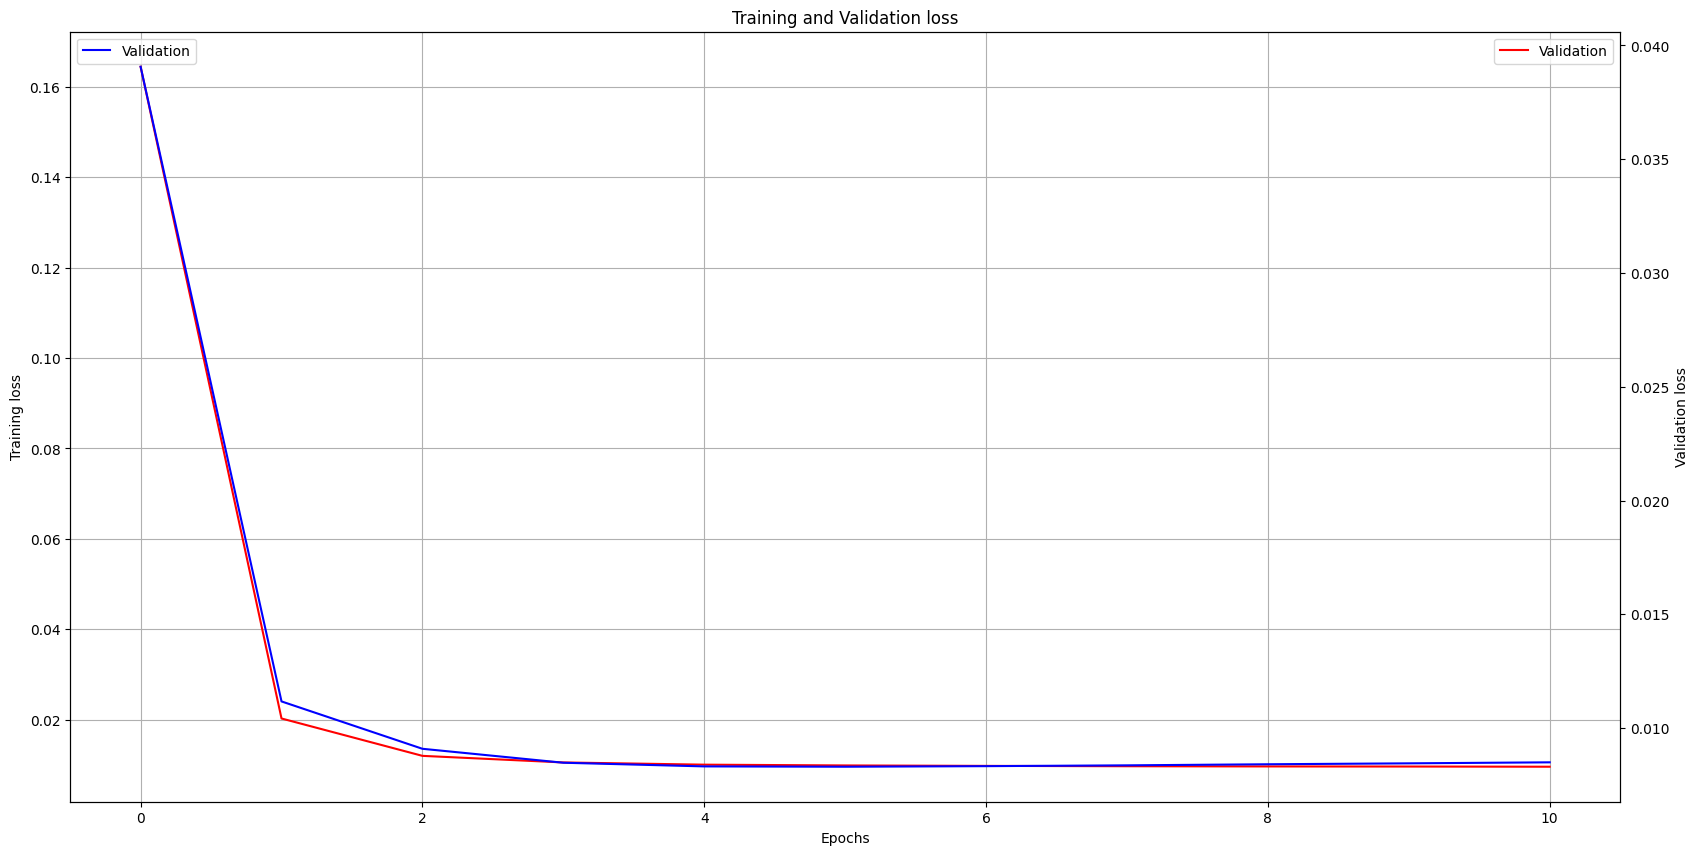

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.plot(history.history["loss"], color="red", label="Validation")
axl = ax.twinx()
axl.plot(history.history["val_loss"], color="blue", label="Validation")
axl.set_ylabel("Validation loss")
axl.legend(loc="upper left")
ax.set_xlabel("Epochs")
ax.set_ylabel("Training loss")
ax.legend()
ax.grid()
ax.set_title("Training and Validation loss")

# Explore the predictions


In [16]:
Y_test_predicted_scaled = model.predict(X_test_scaled_reduced)
Y_test_predicted = Y_test_scaler.inverse_transform(Y_test_predicted_scaled)
Y_test_true = Y_test_scaler.inverse_transform(Y_test_scaled)

Y_train_predicted_scaled = model.predict(X_train_scaled_reduced)
Y_train_predicted = Y_train_scaler.inverse_transform(Y_train_predicted_scaled)
Y_train_true = Y_train_scaler.inverse_transform(Y_train_scaled)

343/343 [==============================] - 1s 3ms/step


Text(0.5, 1.0, 'On test set')

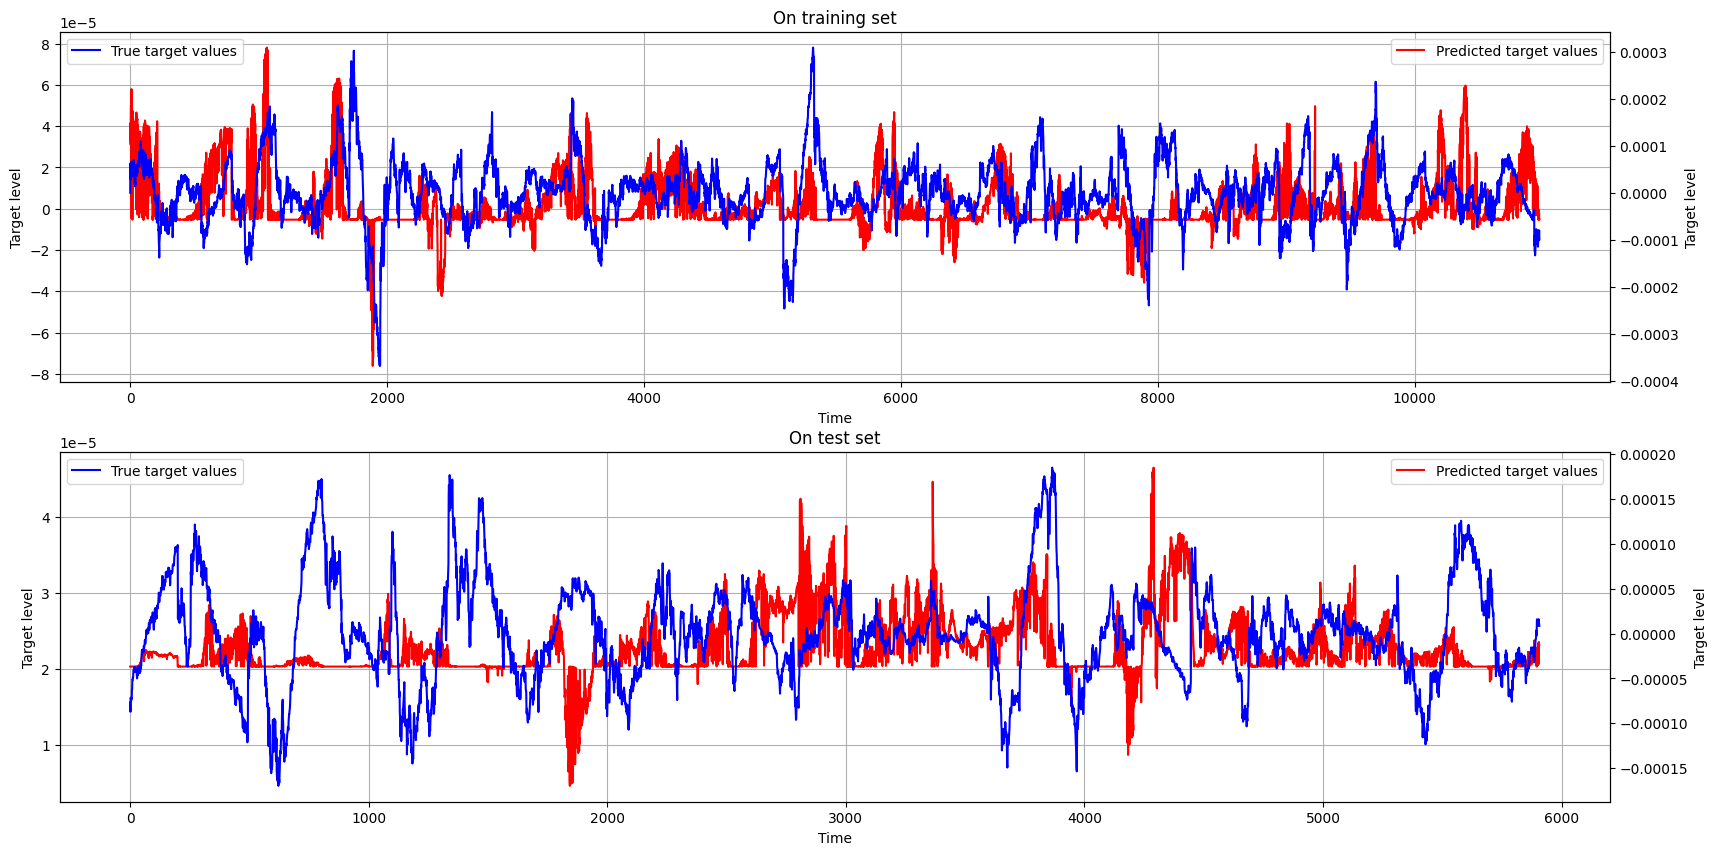

In [17]:
fig, ax = plt.subplots(2, 1, figsize=(20, 10))
ax[0].plot(Y_train_predicted, color="red", label="Predicted target values")
axl = ax[0].twinx()
axl.plot(Y_train_true, color="blue", label="True target values")
axl.set_ylabel("Target level")
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Target level")
ax[0].legend()
axl.legend(loc="upper left")
ax[0].grid()
ax[0].set_title("On training set")

ax[1].plot(Y_test_predicted, color="red", label="Predicted target values")
axl = ax[1].twinx()
axl.plot(Y_test_true, color="blue", label="True target values")
axl.set_ylabel("Target level")
ax[1].set_xlabel("Time")
ax[1].set_ylabel("Target level")
ax[1].legend()
axl.legend(loc="upper left")
ax[1].grid()
ax[1].set_title("On test set")

Text(0.5, 1.0, 'On test set')

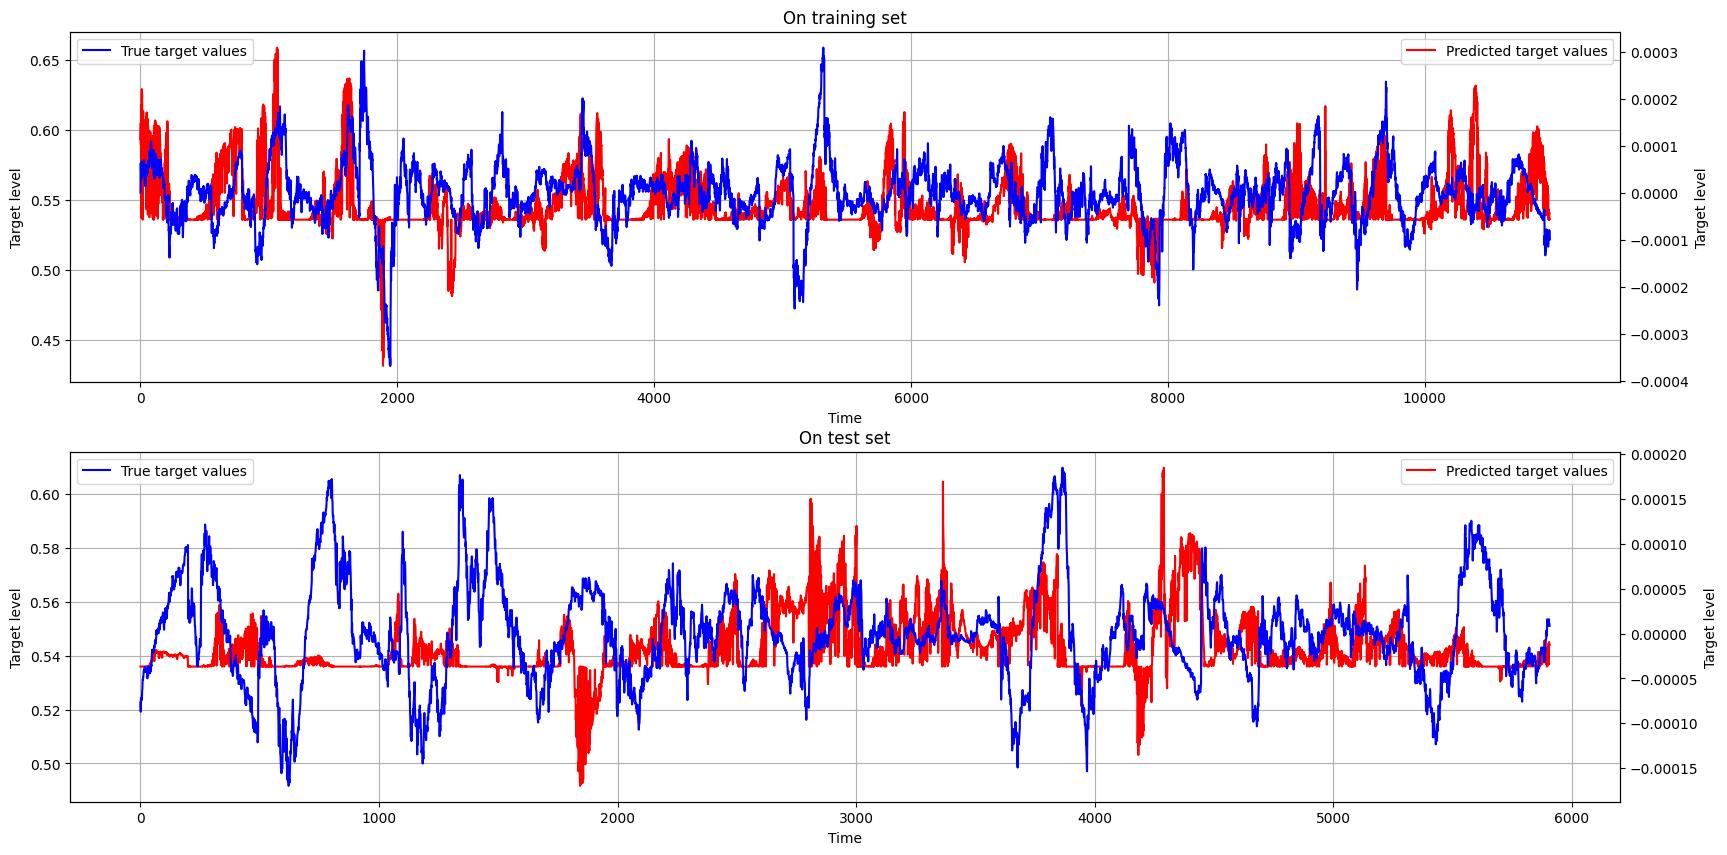

In [18]:
fig, ax = plt.subplots(2, 1, figsize=(20, 10))
ax[0].plot(Y_train_predicted_scaled, color="red", label="Predicted target values")
axl = ax[0].twinx()
axl.plot(Y_train, color="blue", label="True target values")
axl.set_ylabel("Target level")
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Target level")
ax[0].legend()
axl.legend(loc="upper left")
ax[0].grid()
ax[0].set_title("On training set")

ax[1].plot(Y_test_predicted_scaled, color="red", label="Predicted target values")
axl = ax[1].twinx()
axl.plot(Y_test_true, color="blue", label="True target values")
axl.set_ylabel("Target level")
ax[1].set_xlabel("Time")
ax[1].set_ylabel("Target level")
ax[1].legend()
axl.legend(loc="upper left")
ax[1].grid()
ax[1].set_title("On test set")

# Apply Kalman Filter


In [19]:
df["signal"] = np.vstack([Y_train_predicted, Y_test_predicted])
df["signal_filtered"] = np.nan

Z = df[["prices", "target"]].to_numpy()


ukf = UnscentedKalmanFilter(
    dim_x=Z.shape[-1],
    dim_z=Z.shape[-1],
    Q=np.array([[100, 0.0], [0.0, 100]]),
    R=np.array([[100, 0.0], [0.0, 100]]),
)


def f(x, u, v):
    return x + u + v


def h(x, u, n):
    return x + u + n


X_hat, _, X_hat_estim = ukf.fit_predict(
    f, h, z=Z, x0=df[["prices", "signal"]].to_numpy()[0], keep_state_estimates=True
)
df["signal_filtered"] = X_hat_estim[:, 1]

UKF: 100%|██████████| 16879/16879 [00:20<00:00, 831.92it/s]


plotting the effect of kalman filter on the predictions

<Axes: xlabel='date_index'>

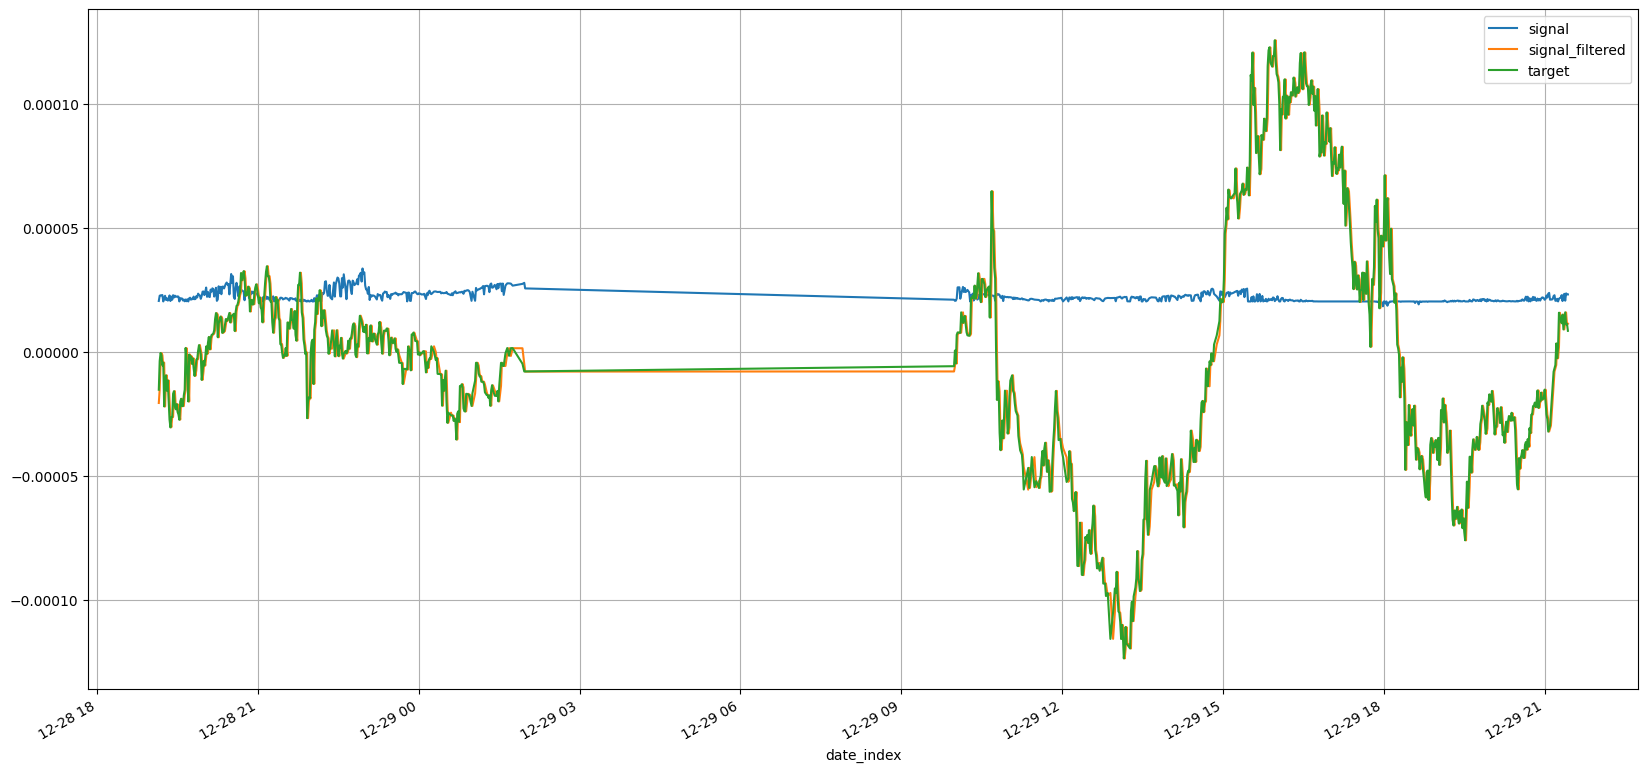

In [20]:
df[["signal", "signal_filtered", "target"]].iloc[-1000:].plot(
    figsize=(20, 10), grid=True
)

# Backtesting the result


In [21]:
df, trades_df = backtest_startegy(
    df,
    buying_threshold=0.0001,
    selling_threshold=-0.0005,
    price_column="prices",
    returns_column="returns",
    date_column="date",
    signal_column="signal_filtered",
    verbose=False,
    trading_fee=0,
    slippage_effect=0,
)

Backtesting...: 100%|██████████| 16880/16880 [00:46<00:00, 361.79it/s]


Text(0.5, 1.0, 'Strategy vs Buy and hold returns')

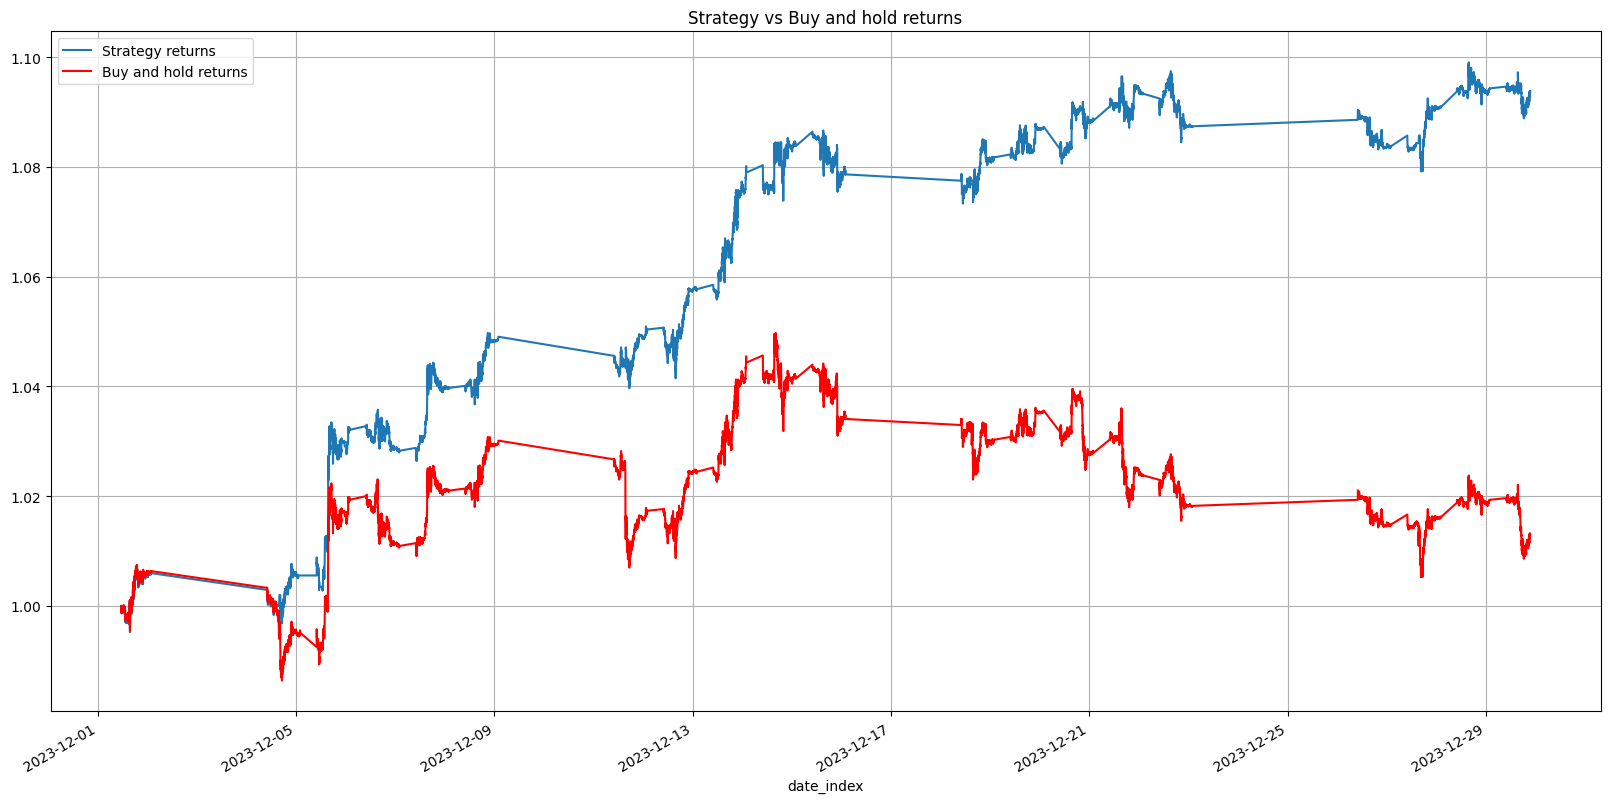

In [22]:
ax = df["strategy_cum_returns"].plot(
    figsize=(20, 10), grid=True, label="Strategy returns"
)
ax.plot(df["cum_returns"], color="red", label="Buy and hold returns")
ax.legend()
ax.set_title("Strategy vs Buy and hold returns")

In [23]:
print_backtest_report(trades_df, df, "1min", initial_equity=1000)
# plot_from_trade_df(df)


------------  Strategy performances  -------------
Strategy final net balance: 1093.68 $, return: 9.37 %
Buy & Hold final net balance: 1013.10 $, returns: 1.31 %
Strategy winrate ratio: 37.02 %
Strategy payoff ratio: 1.12
Strategy profit factor ratio: 1.08
Strategy expectancy: 4.03 %

-------  Returns statistical information  --------
Expected return annualized: 281.68 % vs 43.75 % (buy and hold)
CAGR: 1525.20 % vs 49.95 % (buy and hold)
Expected volatility annualized: 23.90 % vs 25.43 % (buy and hold)
Specific volatility (diversifiable) annualized: 8.15 %
Systematic volatility annualized: 22.46 %
Skewness: 0.50 vs -0.20 (buy and hold), <0 = left tail, >0 = right tail
Kurtosis: 25.00 vs -0.20 (buy and hold) , >3 = fat tails, <3 = thin tails
1min-95%-VaR: -0.05 % vs -0.05 % (buy and hold) -> the lower the better
1min-95%-CVaR: -0.08 % vs -0.08 % (buy and hold) -> the lower the better

-------  Strategy statistical information  -------
Max drawdown: -1.67 % vs -4.24 % (buy and hold)
Kel

## Stopping time prediction

<Axes: >

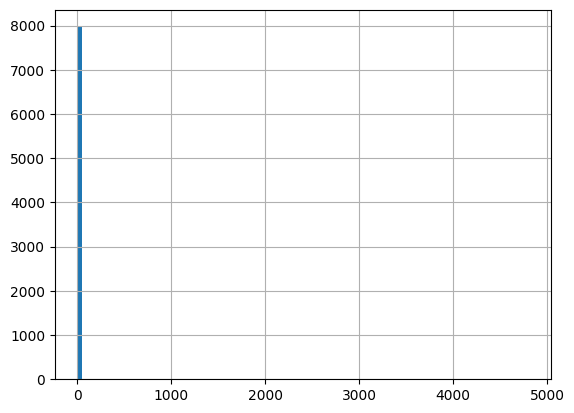

In [24]:
trades_df.trade_duration.apply(lambda x: x.total_seconds()/ 60).hist(bins=100)